<img src=attachment:f8e14a15-e64f-4205-b8fd-81179f85d9df.png width=1000>
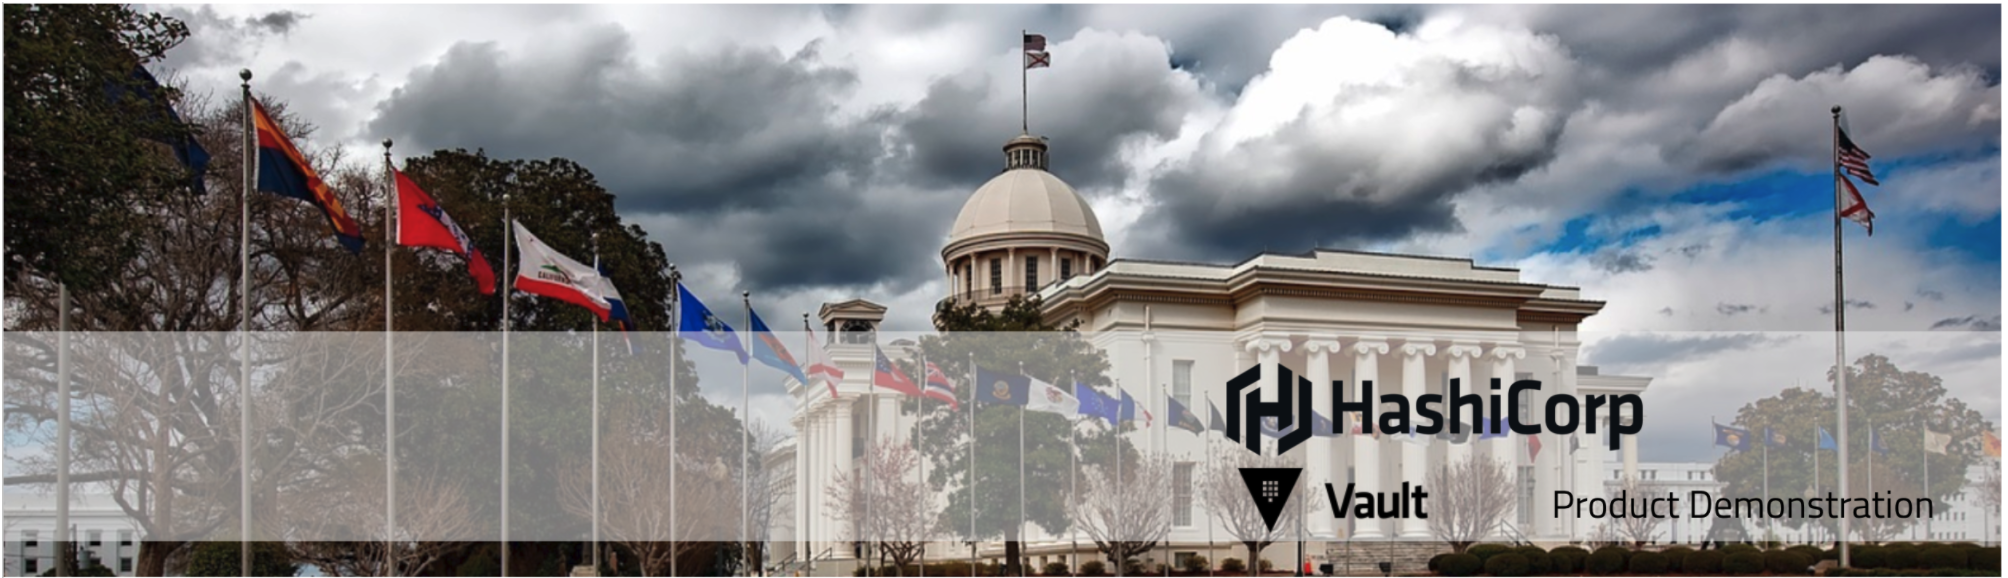

# Vault Encryption As A Service

## Business Value of Capability
 * A centrally managed resource that can encrypt any data for the organization at scale
 * Remove decision of which ciphers to use from the users doing the encryption. 
 * High performance - Vault will encrypt at higher rates (20K+ requests/sec) than the cloud providers solutions.

### Prerequisites
* Running Vault Enterprise instance (even in dev mode) 

<img src=attachment:image.png width=1000>
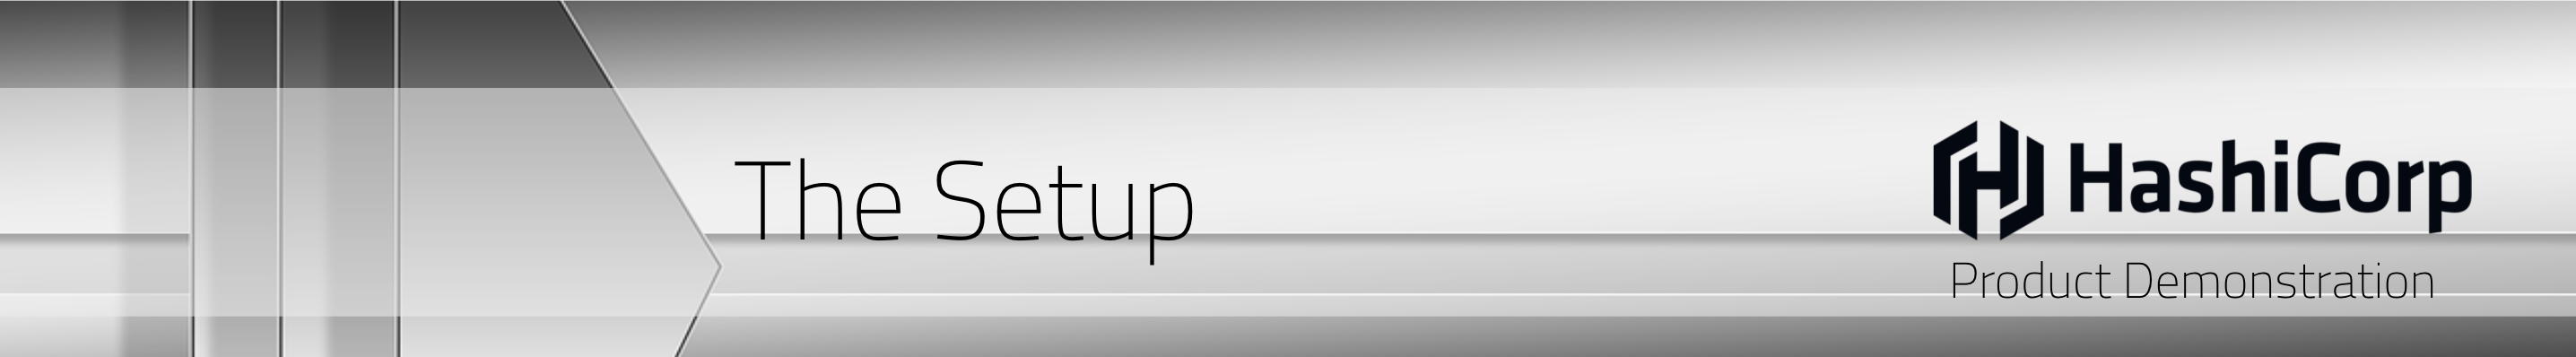

In [ ]:
vault -version

In [ ]:
export VAULT_ADDR=http://127.0.0.1:8200
export VAULT_TOKEN=root
export VAULT_SKIP_VERIFY=true

In [ ]:
vault login root

In [ ]:
vault status

<img src=attachment:5bf4707f-15a3-454f-b2c1-4f878af3f767.png width=800>
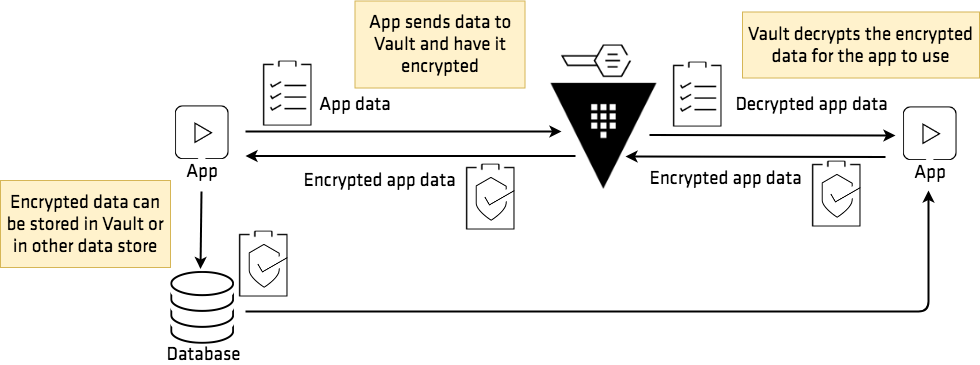

## Personas and Setup
* We need to set up the right policies first
* We also need two roles: admin managing the creds and apps requesting service

---
### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Initial Policies</span>

In [ ]:
mkdir ./config
cat << EOF > ./config/eaas-policy.hcl
# Enable transit secrets engine
path "sys/mounts/transit" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}

# To read enabled secrets engines
path "sys/mounts" {
  capabilities = [ "read" ]
}

# Manage the transit secrets engine
path "transit/*" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}

EOF

In [ ]:
# Add the policy 
vault policy write eaas ./config/eaas-policy.hcl

---
### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Enable the Transits Engine</span>

In [ ]:
vault secrets enable transit

---
### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Create an Encryption Key Ring</span>

In [ ]:
## we create a key ring at this path
vault write -f transit/keys/orders

---
### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Vault Client Tokens and their Policies</span>

### In order for the clients to access Vault to request encryption/decryption services, they will need a token. 

1. We first set up a policy for those tokens (called app-orders)
2. Create tokens with this app-orders policy attached 

<img src=attachment:73ccf5ca-aec1-4538-adb6-0fce4112fba6.png width=800>
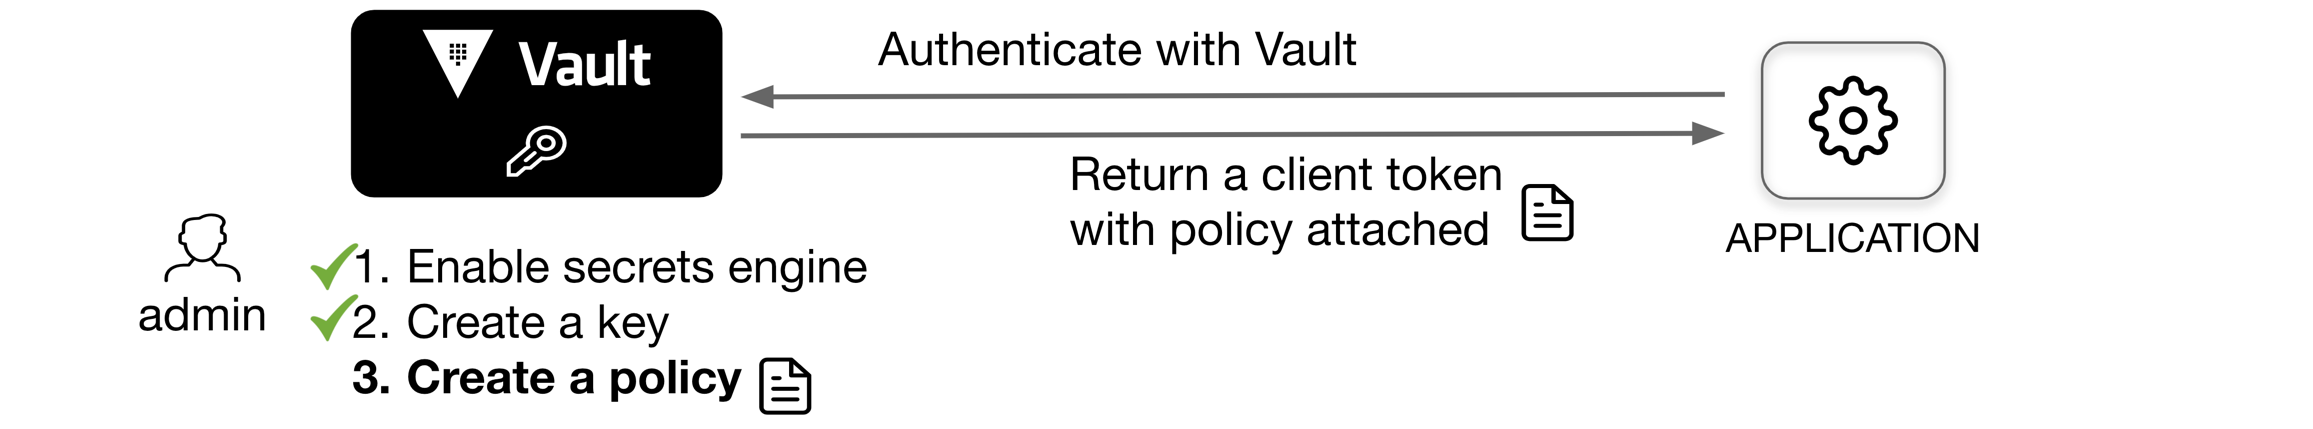

In [ ]:
## Create a policy for encrypting decrypting on the path for orders
vault policy write app-orders -<<EOF
path "transit/encrypt/orders" {
   capabilities = [ "update" ]
}
path "transit/decrypt/orders" {
   capabilities = [ "update" ]
}
EOF

---
### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Create a token with this policy attached</span>

### This client token represents an application accessing Vault rather than the admin user.

In [ ]:
## create token - and we store it in an ENV Variable. 
## If YOU PREFER USING CLI:  vault token create -policy=app-orders

## USING HTTP API : 
CLIENT_TOKEN=$(curl -s --header "X-Vault-Token: ${VAULT_TOKEN} " \
       --request POST  \
       --data '{ "policies": ["app-orders"] }' \
       http://127.0.0.1:8200/v1/auth/token/create | jq -r '.auth.client_token')

echo "Client Token: ${CLIENT_TOKEN}"

---

<img src=attachment:image.png width=1000>

## Let's begin encrypting...

#### To encrypt, you need to hit the endpoint  

````vault write transit/encrypt/<key_ring_name>````
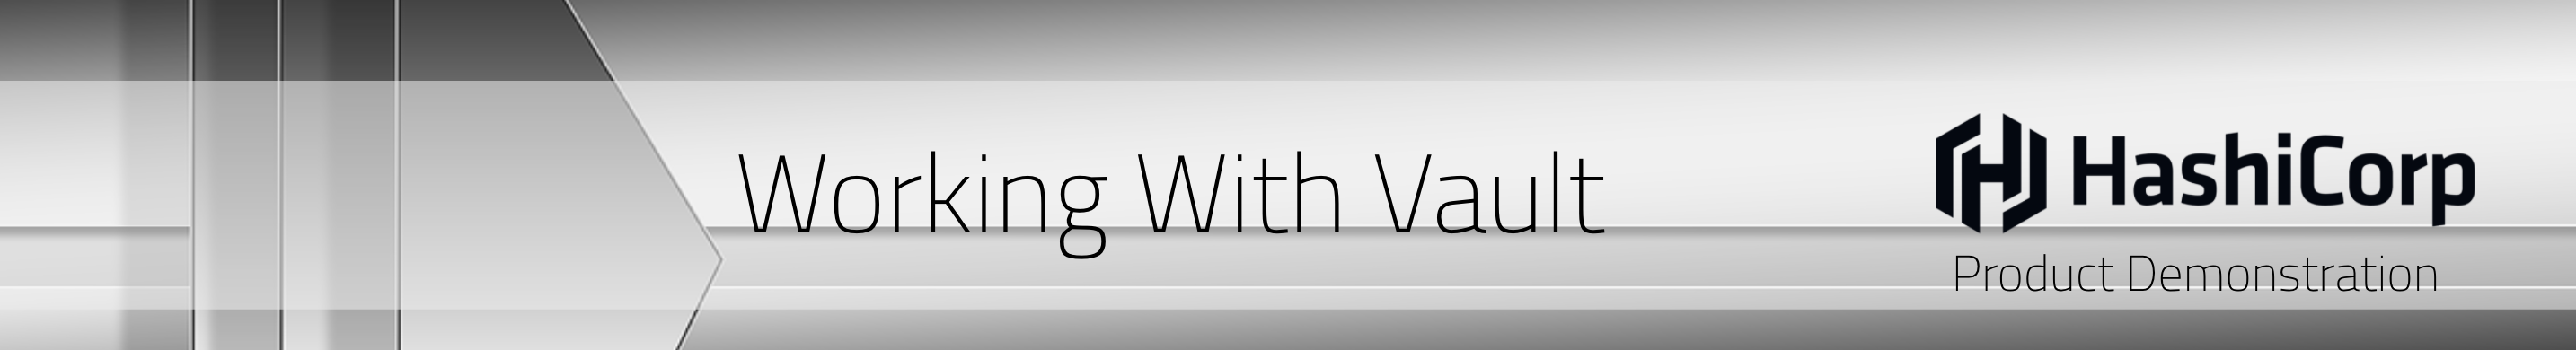

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Encrypt using the CLI</span>

In [ ]:
## pass some plaintext as if a normal vault client
## VAULT_TOKEN=$CLIENT_TOKEN ;vault write transit/encrypt/orders \
    ## plaintext=$(base64 <<< "This is my demo plaintext")
PLAIN=$(base64 <<< "This is my demo plaintext")

## using the http api 
CIPHERTEXT=$(curl -s --header "X-Vault-Token: ${CLIENT_TOKEN}" \
       --request POST \
       --data '{"plaintext": "'"${PLAIN}"'"}' \
       http://127.0.0.1:8200/v1/transit/encrypt/orders | jq -r '.data.ciphertext')
echo "------------------------------>"
echo "Plaintext : "
echo "${PLAIN}" | base64 --decode
echo "------------------------------>"
echo "Plaintext in Base 64 : ${PLAIN}"
echo "------------------------------>"
echo "Ciphertext: ${CIPHERTEXT}"
echo "------------------------------>"

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Decrypt Ciphertext</span>

In [ ]:
DECIPHER=$(curl -s --header "X-Vault-Token: ${CLIENT_TOKEN}" \
     --request POST \
     --data '{"ciphertext": "'"${CIPHERTEXT}"'"}' \
    http://127.0.0.1:8200/v1/transit/decrypt/orders | jq -r '.data.plaintext')

echo "------------------------------>"
echo "Ciphertext: ${CIPHERTEXT}"
echo "------------------------------>"
echo "Plaintext in Base 64 : ${DECIPHER}"
echo "------------------------------>"
echo "Plaintext : "
echo "${DECIPHER}" | base64 --decode
echo "------------------------------>"

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Rotating the Encryption key</span>
---

One of the benefits of using the Vault transit secrets engine is its ability to easily rotate encryption keys. Keys can be rotated manually by a human or by an automated process which invokes the key rotation API endpoint through cron, a CI pipeline, a periodic Nomad batch job, Kubernetes Job, etc.

In [ ]:
# Rotate the encryption key
export VAULT_TOKEN=root
vault write -f transit/keys/orders/rotate

In [ ]:
## Encrypt again and compare
## using the http api 
CIPHERTEXT2=$(curl -s --header "X-Vault-Token: ${CLIENT_TOKEN}" \
       --request POST \
       --data '{"plaintext": "'"${PLAIN}"'"}' \
       http://127.0.0.1:8200/v1/transit/encrypt/orders | jq -r '.data.ciphertext')
echo "------------------------------>"
echo "Plaintext : "
echo "${PLAIN}" | base64 --decode
echo "------------------------------>"
echo "Plaintext in Base 64 : ${PLAIN}"
echo "------------------------------>"
echo "Original Ciphertext: ${CIPHERTEXT}"
echo "------------------------------>"
echo "New Ciphertext: ${CIPHERTEXT2}"
echo "------------------------------>"


### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Rewrap the older version of ciphertext</span>

In [ ]:
## You can take the original ciphertext and rewrap it with the new key (ONLY ADMIN CAN DO THIS)
## NOTICE THE TOKEN WE USE HERE
REWRAP_CIPHERTEXT=$(curl -s --header "X-Vault-Token: ${VAULT_TOKEN}" \
   --request POST \
   --data '{"ciphertext": "'"${CIPHERTEXT}"'" }' \
   http://127.0.0.1:8200/v1/transit/rewrap/orders | jq -r '.data.ciphertext')
   
echo "------------------------------>"
echo "Plaintext : "
echo "${PLAIN}" | base64 --decode
echo "------------------------------>"
echo "Plaintext in Base 64 : ${PLAIN}"
echo "------------------------------>"
echo "Original Ciphertext: ${CIPHERTEXT}"
echo "------------------------------>"
echo "New Ciphertext: ${CIPHERTEXT2}"
echo "------------------------------>"
echo "Rewrapped Ciphertext: ${REWRAP_CIPHERTEXT}"
echo "------------------------------>"

## Note that the rewrapped ciphertext has a 'v2' in it. 

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Update Key Configuration</span>

A Vault admin can update the encryption key configuration to specify the minimum version of ciphertext allowed to be decrypted,  
the minimum version of the key that can be used to encrypt the plaintext, and if the key is allowed to be deleted, etc. for _**increased security**_.

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Rotate keys a few times (more versions)</span>

In [ ]:
export VAULT_TOKEN=root
vault write -f transit/keys/orders/rotate
vault write -f transit/keys/orders/rotate
vault write -f transit/keys/orders/rotate
vault write -f transit/keys/orders/rotate
vault write -f transit/keys/orders/rotate

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Read the order key information back</span>

In [ ]:
vault read transit/keys/orders

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Set a Minimum Decryption Version</span>

In [ ]:
vault write transit/keys/orders/config min_decryption_version=5

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Read the new Key Configuration</span>

In [ ]:
vault read transit/keys/orders

### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Generate key Data</span>

When you encrypt your data, the encryption key used to encrypt the plaintext is referred to as a data key.  
This data key needs to be protected so that your encrypted data cannot be decrypted easily by an unauthorized party.  
During the encrypt secrets step, you encrypted your data by specifying the key ring name (_orders_);  
the actual data key used to encrypt the data was never presented to you.

In this next step, we are going to use the `transit/datakey` endpoint which returns the plaintext of a named data key.

**Why would you need this?**

Think of a scenario where you have a 2GB base64 binary large object (blob) that needs to be encrypted.  
You probably don't want to transmit the 2GB file over the network to Vault and back.  
Instead, you can generate a data key and encrypt it locally and use the same data key to decrypt it _**locally**_ when needed.

The purpose of data keys is to enable applications to encrypt and decrypt data without round-tripping the data through Vault.

The data key is its own full key; you can't decrypt it with the transit key that it is wrapped with.  
However, because the data key is wrapped by a transit key, and thus protected, you can store it with the data.  
This way, you can control which Vault clients can decrypt the data through policies.

In [ ]:
vault write -f transit/datakey/plaintext/orders

The response contains the **plaintext** of the data key as well as its **ciphertext**. Use the plaintext to encrypt your blob.  
Store the ciphertext of your data key wherever you want. You can even store it in the key/value secrets engine.

When you need to decrypt the blob, request Vault to decrypt the ciphertext of your data key (decrypt ciphertext) so  
that you can get the plaintext back to decrypt the blob locally. In other words, once your blob is encrypted, you  
don't have to persist the data key. You only need to keep the ciphertext version of the data key.

<img src=attachment:image.png width=1000>
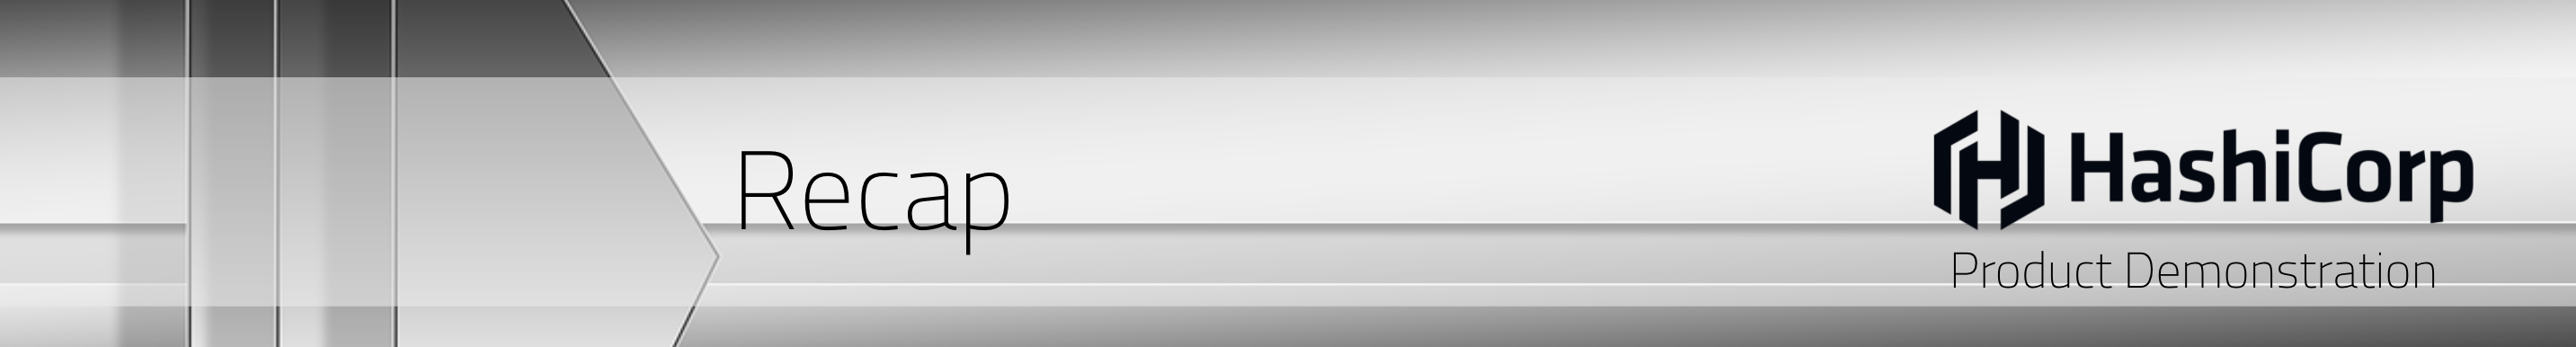

* ## <span style="color: #001f3f; padding: 15px; border-radius: 2px">Setup the transits engine for EaaS</span>
* ## <span style="color: #001f3f; padding: 15px; border-radius: 2px">Configured a keyring and did some encryption and decryption of text</span>
* ## <span style="color: #001f3f; padding: 15px; border-radius: 2px">Rotated the keys and Rewrapped older version ciphertext</span>
* ## <span style="color: #001f3f; padding: 15px; border-radius: 2px">Modified key config and generated  key data</span>

In [ ]:
# cleanup
vault secrets disable transit

In [ ]:
# cleanup
rm -r ./config